
# Practical Session - GAN

The goal of this exercice is to create a DCGAN to generate Manga faces.

## Roadline : 
- Setup the workplace 
  1. Enable the **GPU**
  2. Install and import the **Pytorch library**

  
- DCGAN implementation in Pytorch explained 
  0. Import libraries needed 
  1. Load and Prepare dataset
  2. Generator 
  3. Discriminator 
  4. Generator - Discriminator Loss
  5. Optimizer 
  6. Train 


## Setup the workplace 


1. Enable the **GPU** 


Getting Starting, you need to **enable** the GPU as hardware accelerator : 

             »Edit »Notebook settings »select GPU » SAVE.


and check the GPU type : 

In [ ]:
!nvidia-smi

Mon Nov  2 22:50:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

  2. **install** and **import** the *PyTorch library* 

In [ ]:
#!pip3 install torch torchvision
import torch

## DCGAN implementation in Pytorch

  ### 0. Libraries importation 

For this project, we need to import several packages

In [ ]:
import numpy as np
import os
import random
import glob
import time

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision.utils import make_grid
import torchvision.utils as vutils

from PIL import Image
import matplotlib.animation as animation
from IPython.display import HTML
from IPython import display
import matplotlib.pyplot as plt


### 1. Load and Prepare dataset

1) Download the Manga face dataset by cloning the github project of Yaohui Wang 

2) and then unzip the images folder

3) To take a look at the dataset, display the image you want and the associated size

4) Prepare the loaded MangaFace dataset as training set

5) Show the size of the training set 

In [ ]:
# 1) download dataset
!git clone https://gitlab.inria.fr/yaowang/gan_class_images.git

Cloning into 'gan_class_images'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.


In [ ]:
# 2) cd images folder and unzip 
!cd gan_class_images;unzip images.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: images/14625.jpg        
  inflating: images/6385.jpg         
  inflating: images/7921.jpg         
  inflating: images/18321.jpg        
  inflating: images/32888.jpg        
  inflating: images/1003.jpg         
  inflating: images/16799.jpg        
  inflating: images/8748.jpg         
  inflating: images/8425.jpg         
  inflating: images/14554.jpg        
  inflating: images/14586.jpg        
  inflating: images/36729.jpg        
  inflating: images/35430.jpg        
  inflating: images/10188.jpg        
  inflating: images/1673.jpg         
  inflating: images/36356.jpg        
  inflating: images/27328.jpg        
  inflating: images/1712.jpg         
  inflating: images/440.jpg          
  inflating: images/30384.jpg        
  inflating: images/27859.jpg        
  inflating: images/28374.jpg        
  inflating: images/14321.jpg        
  inflating: images/12997.jpg        
  inflatin

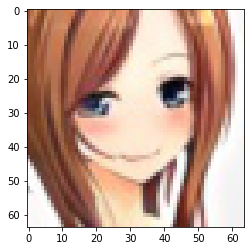

(64, 64, 3)


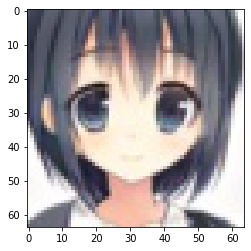

(64, 64, 3)


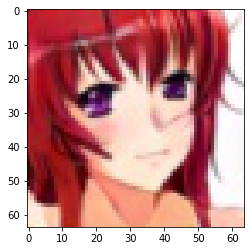

(64, 64, 3)


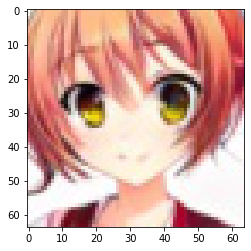

(64, 64, 3)


In [ ]:
# 3) Display one image in the training set and the associated size
# We here chose to display   
# image1 = 5846.jpg 
image1 = plt.imread('gan_class_images/images/5846.jpg')
plt.imshow(image1)
plt.show()
print(image1.shape)

# image2 = 240.jpg
image2 = plt.imread('gan_class_images/images/240.jpg')
plt.imshow(image2)
plt.show()
print(image2.shape)

image3 = plt.imread('gan_class_images/images/8672.jpg')
plt.imshow(image3)
plt.show()
print(image3.shape)

# image2 = 240.jpg
image4 = plt.imread('gan_class_images/images/7369.jpg')
plt.imshow(image4)
plt.show()
print(image4.shape)

In [ ]:
# 4) Prepare the MangaFace Dataset as training set with the help of *class*

class MangaFace(Dataset):
    def __init__(self, root, transform=None):
        """Initialize Pokemon."""
        self.transform = transform
        self.root = root
        self.imgs = glob.glob(self.root + '*')

    def __getitem__(self, idx):
        """Get item from Pokemon class.
        Args:
            index (int): Index
        Returns:
            img: PIL Image.
        """
        img = self.imgs[idx]
        img = Image.open(img).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return img

    def __len__(self):
        """Get length."""
        return len(self.imgs)

In [ ]:
# 5) Show the size of the training set

# normalize all image included on the loaded dataset : 
train_transform = transforms.Compose([
                                      transforms.Resize((64,64)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Define the trainset thanks to MangaFace :
trainset = MangaFace(root='./gan_class_images/images/', transform=train_transform)

# Show the size :
print("Size of the training set : ", len(trainset))

Size of the training set :  36740


### Define Generator and Discriminator networks 

Preliminary work :

1) Define parameters

2) Set device - using GPU

3) Network weights initialization

In [ ]:
# 1) Define parameters 

batch_size = 128  # or other 64, 32 
beta1 = 0.5       # for the optimization function 
lr = 2e-4         # learning rate 
nz = 100          # input dimension 
num_epochs = 100  # trainings 
num_workers = 8

In [ ]:
# 2) Set device - we use GPU 
device = torch.device("cuda:0")

In [ ]:
# 3) Network weights initialization 
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)      # N(0,0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)      # N(1,0.02)
        m.bias.data.fill_(0)

### 2. Generator Network


For this project : 

  > input size: batchsize * 100 * 1 * 1

  > output size: batchsize * 3 * 64 * 64


  In oder to generate image from the input noise, we use the operator **ConvTranspose2d** to upsample spatial dimension : 

    nn.ConvTranspose2d(in-channels , out-channels, kernel-size, stride, padding)

1) Define the Generator Network 

2) Test the Generator 


In [ ]:
# Summary of the generator : 
"""
* 1st layer:
transposed convolution
batch norm
relu

* 2nd layer
transposed convolution
batch norm
relu

* 3rd layer
transposed convolution
batch norm
relu

* 4th layer
transposed convolution
batch norm
relu

* 5th layer
transposed convolution
tanh
"""


# 1) Define the Generator Network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # TODO:

          # input = bs * 100 * 1 * 1
          # output = bs * 3 * 64 * 64
           
        self.net = nn.Sequential(   
        # 1st layer output: bs * 512 * 4 * 4
          nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=True),
          nn.BatchNorm2d(512),
          nn.ReLU(inplace=True),
        # 2nd layer output: bs * 256 * 8 * 8    
          nn.ConvTranspose2d(512, 256, 4, 2, 1),
          nn.BatchNorm2d(256),
          nn.ReLU(inplace=True),
        # 3rd layer output: bs * 128 * 16 * 16
          nn.ConvTranspose2d(256, 128, 4, 2, 1),
          nn.BatchNorm2d(128),
          nn.ReLU(True),
        # 4th layer output: bs * 64 * 32 * 32
          nn.ConvTranspose2d(128, 64, 4, 2, 1),
          nn.BatchNorm2d(64),
          nn.ReLU(True),
        # 5th layer output: bs * 3 * 64 * 64
          nn.ConvTranspose2d(64, 3, 4, 2, 1),
          nn.Tanh()
        )
    def forward(self, x):
      
        out = self.net(x)

        return out

In [ ]:
net = Generator()
print(net)

Generator(
  (net): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)


In [ ]:
# 2) Test the Generator
# input : 8 tensor with 100 channels of 1x1 
z = torch.randn(8, 100, 1, 1)

net = Generator()
# output through the Generator "net" : 8 tensor with 3 channels (RGB) of 64x64
out = net(z) # 8 * 3 * 64 * 64

### 2. Discriminator Network 

The discriminator take as input a real data or a generated data and perform a binary classification. 

  > input size:  batchsize * 3 * 64 * 64

  > output size: batchsize * 1


1) Define the Discriminator Network 

2) Test the Discriminator 

In [ ]:
# Summary of the discriminator : 
"""
* 1st layer:
convolution
Leakyrelu

* 2nd layer
convolution
batch norm
Leakyrelu

* 3rd layer
convolution
batch norm
Leakyrelu

* 4th layer
convolution
batch norm
Leakyrelu

* 5th layer
convolution
sigmoid
"""


# 1) Define the Discriminator Network

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(
        # 1st layer output: bs * 64 * 32 * 32
          nn.Conv2d(3, 64, 4, 2, 1),
          #nn.ReLU(True),
          nn.LeakyReLU(0.2, True),
        # 2nd layer output: bs * 128 * 16 * 16    
          nn.Conv2d(64, 128, 4, 2, 1),
          nn.BatchNorm2d(128),
          nn.LeakyReLU(0.2, True),
        # 3rd layer output: bs * 256 * 8 * 8
          nn.Conv2d(128, 256, 4, 2, 1),
          nn.BatchNorm2d(256),
          nn.LeakyReLU(0.2, True),
        # 4th layer output: bs * 512 * 4 * 4
          nn.Conv2d(256, 512, 4, 2, 1),
          nn.BatchNorm2d(512),
          nn.LeakyReLU(0.2, True),
        # 5th layer output: bs * 1
          nn.Conv2d(512, 1, 4, 1, 0),
          nn.Sigmoid()
        )
    def forward(self, x):

        out = self.net(x)

        return out.squeeze(-1).squeeze(-1)

In [ ]:
# 2) Test the Discriminator
# input : 4 tensor with 3 channels of 64x64 
x = torch.randn(4, 3, 64, 64)

net = Discriminator()
# output through the Discriminator "net" : 
out = net(x) 
print(out.size()) # 4 * 1

torch.Size([4, 1])


### Display Function

In [ ]:
def display_demos(fixed_noise, epoch, iters):

  img_list = []
  with torch.no_grad():

    fake = netG(fixed_noise).detach().cpu()
    plt.rcParams[ "figure.figsize" ]=10,10
    plt.clf()
    plt.title('epoch: %d iteration: %d' % (epoch, iters))
    img = make_grid(fake.data * 0.5 + 0.5).cpu() 
    plt.imshow (img.permute(1, 2, 0).numpy())
    display.display( plt.gcf() )
    display.clear_output (wait=True)
    time.sleep (1.0)

### Main for G and D

In [ ]:
# define G, D and initialize parameters
# We have to put it into GPU
netG = Generator().to(device)
netD = Discriminator().to(device)
netG.apply(weights_init)
netD.apply(weights_init)


Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
)

### 4. Generator - Discriminator Loss

In [ ]:
# define loss function 
# hint: binary cross entropy
criterion = nn.BCELoss().to(device)

In [ ]:
#img_list for loss
G_losses = []
D_losses = []
iters = 0

### 5. Optimizer

In [ ]:
# Create batch of latent vectors (64 * nz * 1 * 1) that we will use to visualize
# hint: torch.randn
fixed_noise = torch.randn(64, 100, 1, 1).to(device)

In [ ]:
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### 6. Train

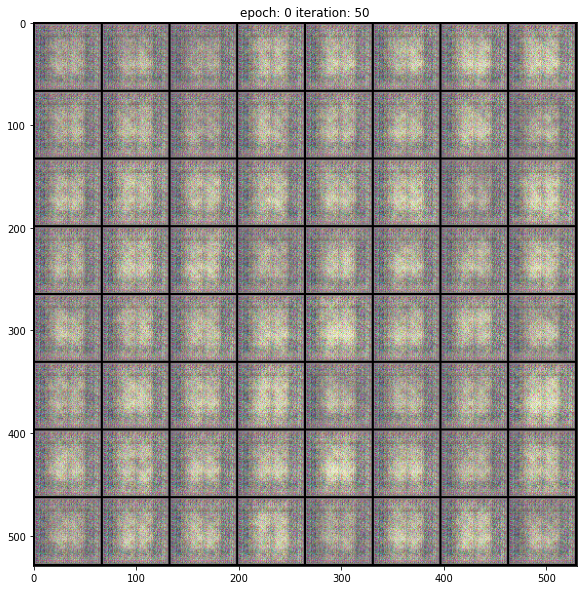

In [ ]:
dataset = MangaFace(root='./gan_class_images/images/', transform=train_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)


print("==> start training")
for epoch in range(num_epochs):
  # For each batch in the dataloader
  for i, data in enumerate(dataloader):
    ############################
    # Update D network
    # maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    # put data into gpu
    real_imgs = data.to(device)

    ## Train with all-real batches
    # set D gradient 0
    netD.zero_grad()

    # Forward pass real batch through D
    output = netD(real_imgs)

    # set ground truth label 1
    label_real = torch.ones(output.size()).to(device)

    # Calculate loss on all-real batch
    errD_real = criterion(output, label_real)

    # Calculate gradients for D in backward pass
    errD_real.backward()

    ## Train with all-fake batch
    # Generate batch of latent vectors
    noises = torch.randn(output.size(0), 100, 1, 1).to(device)

    # Generate fake image batch with G
    fake = netG(noises)

    # Classify all fake batch with D
    output = netD(fake.detach())

    # set ground truth label 0
    label_fake = torch.zeros(output.size()).to(device)

    # Calculate D's loss on the all-fake batch
    errD_fake = criterion(output, label_fake)

    # Calculate the gradients for this batch
    errD_fake.backward()

    # Add the gradients from the all-real and all-fake batches
    errD = errD_real + errD_fake

    # Update D
    optimizerD.step()

    ############################
    # Update G network
    # maximize log(D(G(z)))
    ###########################
    # set G gradient 0
    netG.zero_grad()

    # Since we just updated D, perform another forward pass of all-fake batch through D
    output = netD(fake)

    # Calculate G's loss based on this output
    errG = criterion(output, label_real)

    # Calculate gradients for G
    errG.backward()

    # Update G
    optimizerG.step()

    # Save Losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())

    # display demo images each 50 iterations
    if iters % 50 == 0:
      display_demos(fixed_noise, epoch, iters)

    iters += 1

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

#3  REPORT
#1. Dataset
#i. Print four images of the Manga face dataset

In [ ]:
image1 = plt.imread('gan_class_images/images/2118.jpg')
plt.imshow(image1)
print(image1.shape)

image2 = plt.imread('gan_class_images/images/198.jpg')
plt.imshow(image2)
print(image2.shape)

image3 = plt.imread('gan_class_images/images/8672.jpg')
plt.imshow(image3)
print(image3.shape)

image4 = plt.imread('gan_class_images/images/7369.jpg')
plt.imshow(image4)
plt.show()
print(image4.shape)

#ii.  What is the input size of the images contained in the Manga face dataset ?Print the shape.
 the input size is (64,64,3)

In [ ]:

print(image1.shape)
print(image2.shape)
print(image3.shape)
print(image4.shape)

#iii.  What is the size of the training set ? 
 Show the size : The size is 36740

In [ ]:

print("The size of the training set : ", len(trainset))

#2. Networks
#A. About the Generator 
#i. How many block-ﬁlters are needed to build the generator network ?
    5 block-filters are needed
#ii. What is the size of the image generated by the generator network ? Print the size
    The size is 8 * 3 * 64 * 64

In [ ]:

output = net(z) # 8 * 3 * 64 * 64
print(output.size())

#B. About the Discriminator 
#i. How many block-ﬁlters are needed to build the discriminator network ? 
    5 block-filters are needed to build the discriminator network.
#ii. What is the size of the discriminator output ?
    The size of the discriminator output is 4 * 1

#C. Parameters 
#i. What is the dimension of the input noise ? 
 The dimension of the input noise is 100.
#ii. For the training experiment, how many epochs is chosen ?
  100 epochs is chosen 
#iii. Indicate the learning rate lr.
  The learning rate is : lr = 2e-4 = 0.0002.


#3. Objective - Loss
#i. Which criterion is chosen in order to deﬁne the loss function ? 
    It is the binary cross entropy.
#ii. Brieﬂy comment the ﬁgure "Generator and Discriminator Loss During Training". What can we conclude ? 
    We can conclude that the face generation is better because at the   beginning, the two curves are very rondom, but sometimes, they reach a constant.

#4. After Training

In [ ]:
display_demos(fixed_noise, epoch, iters)

At the beginning of training, the generation of faces is still in its infancy and no faces are really visible. From the threshold of the epoch, we have relatively good results with a lot of variety. The face, eyes and hair are there and some pictures have a mouth and/or a noise. After this stage, the result can change a lot from one era to another, for example the mouth can appear or disappear. The final result can sometimes be very disappointing, when most of the photos seem to follow the same pattern. The loss is usually good with such a convergence and stops acting randomly.



#4 Exercises
#Exercise 1. GANs have gained massive attraction in the ﬁeld of computer vision. Provide at least three examples of application areas where GANs are presents ? 

We have for example Image-to-Image Translation, Face Frontal View Generation, Photos to Emojis.

#Exercise 2. Adversarial Game The optimization competition of the Generator network G and the Discriminator network D results in the following minimax game
 1. The role of the discriminator Network is to distinguish real data from the data created by the generator and D(x) indicates the chance that x is a real image.

 2. A generator is used to generate real-looking images.
 It learns to create fake data by incorporating feedback from the discriminator.
 x is drawn from data distribution Pdata, z is drawn from a prior distribution Pz. The mapping G (z) induces a generator distribution Pmodel in data space. n. G is therefore incentivized to map every z to a single x that is most likely to be classified as true data, leading to mode collapsing problem

 3. The objective of D is to maximize the expectation by pushing both terms towards 0 (i.e. D(x) → 1 and D(G(z)) → 0). On the other hand, G seeks to fool D by minimizing the second term (i.e. D(G(z)) → 1).
 G wants to minimize V while D wants to maximize it. We train both networks in alternating steps until the generator produces good quality images. The generator optimizes for maximally confusing the discriminator, by trying to make it output high probabilities for fake data samples.
 
4. The goal is having an image which is much too real for the discriminator the probability of find which image is real or not is ½ like the probability to flip a coin.

#Exercise 3. 
#1. Implement a basic function which is able to compute the number of parameters after one convolution, and then by using this function determine the number of learnable parameters that the Discriminator network NetD has

In [ ]:
params = lambda C, D, K : (K * K * C + 1) * D
dims = [3, 64, 128, 256, 512, 1]
K = 4

nb_params = 0
for i in range(len(dims)-1) :
  C, D = dims[i : i+2]
  nb_params += params(C, D, K)

print("total of params : {}".format(nb_params))

#2. Implement a basic function which is able to compute the size of the output image after one convolution

In [ ]:
output_size = lambda I, K, S, P : np.floor( (I + 2*P - K) /S ) + 1


#3. For the network described in the Table 3 and with the help of the previous functions implemented in 1. and 2
i. Compute the image size after each convolution according to D, K, S and P
ii. Compute the number of learnable parameters.

In [ ]:
C = 1
I = 28
DKSP = [
  [128, 3, 2, 1],
  [128, 3, 2, 1],
  [1, 5, 3, 0]]

for i,(D,K,S,P) in enumerate(DKSP) :
  O = output_size(I,K,S,P)
  nb_parameters = params(C,D,K)
  print("Layer n°{i} :".format(i=i+1))
  print("input  C x I x I = {C} x {I} x {I}".format(C=C, I=I))
  print("output D x O x O = {D} x {O} x {O}".format(D=D, O=O))
  print("number of parameters : {}".format(nb_parameters))
  C,I = D,O
  pass

iii. Deﬁne the standalone discriminator model described in the Table 3 as : 

In [ ]:
class Discriminatorbis (nn.Module):
  def __init__ (self):
    super(Discriminatorbis, self).__init__()
    self.net = nn.Sequential(
      # 1st layer
      nn.Conv2d(1, 128, kernel_size=3, stride=2, padding=1),
      nn.LeakyReLU(0.2, True),

      # 2nd layer  
      nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
      nn.BatchNorm2d(128),
      nn.LeakyReLU(0.2, True),

      # 3rd layer
      nn.Conv2d(128, 1, kernel_size=5, stride=3, padding=0),
      nn.Sigmoid()
    )
    return
    
  def forward (self ,x):
    out = self.net(x)
    return out.squeeze(-1).squeeze(-1)

4. Based on the formula (4), derive a formula which is able to compute the size of the output coming from the upsampling spatial dimension-convolution performed by the Generator network.

We know that:
$$
I = \left \lfloor  \frac{O + 2 * P - K}{S} \right \rfloor +1 \\
$$
So we can used this formula to compute the size of the ouput coming from the upsamplig spatial dimension-convolution performed by the generator: O = S(I - 1) - 2 * P + K
